In [1]:
import sys
sys.path.append("scripts/")
from GridMap import *
import math
from matplotlib.animation import PillowWriter    #アニメーション保存用

In [2]:
class Dstar():
    def __init__(self, grid_map_world):
        self.world = grid_map_world
        self.real_grid_map = grid_map_world.grid_map #実際のマップ
        self.metric_grid_map = np.full(self.real_grid_map.shape, -1)  #測定により得られたマップ
        self.cost_map = np.full(self.real_grid_map.shape, 1)    #その地点が持つコスト
        self.id_map = np.full(self.real_grid_map.shape, 0)
        self.child_id_map = np.full(self.real_grid_map.shape, 0)
        
        self.h_map = np.full(self.real_grid_map.shape, 10000.0)
        self.k_map = np.full(self.real_grid_map.shape, 10000.0)
        
        self.robot_index = self.world.start_index
        self.flag_path_draw = 0  #経路描画のフラグ
        self.flag_map_update = False  #マップ更新のフラグ
        
        self.open_list = []
        self.closed_list = []
        
        #各グリッドのIDを登録，ゴール地点のコストを決定
        index = 0
        for index_x, grids in enumerate(self.real_grid_map):
            for index_y, grid in enumerate(grids):
                self.id_map[index_x][index_y] = index;
                if(grid == '3'):
                    self.h_map[index_x][index_y] = 0
                    self.k_map[index_x][index_y] = 0
                    self.open_list.append([index, 0])
                index += 1
            
        #既知の地図を用いて各グリッドのコストを生成し，経路を生成する
        while(1):
            val = np.argmin(self.open_list, axis=0) #評価マップの中から最も小さいもの抽出
            grid_id = self.open_list[val[1]][0]
            idx = np.where(self.id_map==grid_id)
            index = [idx[0][0], idx[1][0]]
            cost_h = self.h(index)
            cost_k = self.k(index)


            self.open_list.remove([grid_id, cost_k])  #オープンリストから削除
            self.closed_list.append(grid_id)  #クローズドリストに追加

            if(self.world.grid_map[index[0]][index[1]] == '2'):
                break
            for i in range(-1, 2):
                    if(index[0]+i<0 or index[0]+i>self.cost_map.shape[0]-1): #地図の範囲外か（x軸方向）
                        continue;
                    for j in range(-1, 2):
                        if(index[1]+j<0 or index[1]+j>self.cost_map.shape[1]-1): #地図の範囲外か（y軸方向）
                            continue;
                        if(i==0 and j==0): #自分か
                            continue;
                        elif(self.metric_grid_map[index[0]+i][index[1]+j] == '0'): #障害物か
                            continue;
                        else:
                            neigbor_index = [index[0]+i, index[1]+j]
                            new_cost_h = cost_h + self.c(index, i, j)
                            new_cost_k = new_cost_h
                            if(self.isOpenedGrid(neigbor_index)):
                                #オープンリストに含まれていれば，前のコストと比較する
                                if(self.h(neigbor_index) > new_cost_h):
                                    #比較して新しいコストが低ければ更新
                                    self.open_list.remove([self.id(neigbor_index), self.k(neigbor_index)])
                                    self.h_map[index[0]+i][index[1]+j] = new_cost_h
                                    self.k_map[index[0]+i][index[1]+j] = new_cost_h
                                    self.child_id_map[index[0]+i][index[1]+j] = grid_id
                                    self.open_list.append([self.id(neigbor_index), self.k(neigbor_index)])
                            elif(self.isClosedGrid(neigbor_index)):
                                #クローズドリストに含まれている場合は何もしない
                                continue
                            else:
                                #はじめて探索するグリッド
                                self.h_map[index[0]+i][index[1]+j] = new_cost_h
                                self.k_map[index[0]+i][index[1]+j] = new_cost_h
                                self.child_id_map[index[0]+i][index[1]+j] = grid_id
                                self.open_list.append([self.id(neigbor_index), self.k(neigbor_index)])
    
    def draw(self, ax, elems):        
        #障害物の確認
        self.flag_map_update = False
        for i in range(-3, 6):
                if(self.robot_index[0]+i<0 or self.robot_index[0]+i>self.cost_map.shape[0]-1): #地図の範囲外か（x軸方向）
                    continue;
                for j in range(-3, 6):
                    if(self.robot_index[1]+j<0 or self.robot_index[1]+j>self.cost_map.shape[1]-1): #地図の範囲外か（y軸方向）
                        continue
                    elif(i==0 and j==0): #自分か
                        continue
                    elif(math.sqrt(i**2+j**2) > 3):
                        continue
                    else:
                        neigbor_index = [self.robot_index[0]+i, self.robot_index[1]+j]
                        if(self.metric_grid_map[neigbor_index[0]][neigbor_index[1]] == -1):
                            #まだ探索していないグリッドの場合
                            self.metric_grid_map[neigbor_index[0]][neigbor_index[1]] = self.real_grid_map[neigbor_index[0]][neigbor_index[1]]
                            if(self.real_grid_map[neigbor_index[0]][neigbor_index[1]] == '0'):
                                #新しい障害物の場合
                                r = patches.Rectangle(
                                    xy=((self.robot_index[0]+i)*self.world.grid_step[0], (self.robot_index[1]+j)*self.world.grid_step[1]),
                                    height=self.world.grid_step[0],
                                    width=self.world.grid_step[1],
                                    color="black",
                                    fill=True
                                )
                                ax.add_patch(r)
                                self.flag_map_update = True
                            else:
                                pass
        
        #経路の生成
        child_id = self.id(self.robot_index)
        while(child_id != self.id(self.world.goal_index)):
            child = np.where(self.id_map==child_id)
            child_id = self.child_id_map[int(child[0])][int(child[1])]
            r = patches.Rectangle(
                xy=((child[0])*self.world.grid_step[0], (child[1])*self.world.grid_step[1]),
                height=self.world.grid_step[0],
                width=self.world.grid_step[1],
                color="red",
                fill=True
            )
            #elems.append(ax.add_patch(r))
            
        #ロボットの描画
        print(self.robot_index)
        r = patches.Rectangle(
            xy=((self.robot_index[0])*self.world.grid_step[0], (self.robot_index[1])*self.world.grid_step[1]),
            height=self.world.grid_step[0],
            width=self.world.grid_step[1],
            color="blue",
            fill=True
        )
        elems.append(ax.add_patch(r))
        if(self.id(self.robot_index) != self.id(self.world.goal_index)):
            child_id = self.child_id_map[self.robot_index[0]][self.robot_index[1]]
            child = np.where(self.id_map==child_id)
            self.robot_index = [int(child[0]), int(child[1])]
    
    def isNewGrid(self, index):
        if(self.id_map[index[0]][index[1]] in [val[0] for val in self.open_list]):
            return False
        elif(self.id_map[index[0]][index[1]] in [val[0] for val in self.open_list]):
            return False
        return True
    
    def isOpenedGrid(self, index):
        if(self.id_map[index[0]][index[1]] in [val[0] for val in self.open_list]):
            return True
        else:
            return False
        
    def isClosedGrid(self, index):
        if(self.id_map[index[0]][index[1]] in self.closed_list):
            return True
        else:
            return False
        
    def h(self, index):
        return self.h_map[index[0]][index[1]]
    
    def k(self, index):
        return self.k_map[index[0]][index[1]]
    
    def b(self, index):
        return self.child_id_map[index[0]][index[1]]
    
    def c(self, index, i, j):
        if(self.metric_grid_map[index[0]+i][index[1]+j] == '0'):
            return 10000
        else:
            return math.sqrt(i**2 + j**2)

    def id(self, index):
        return self.id_map[index[0]][index[1]]

<IPython.core.display.Javascript object>


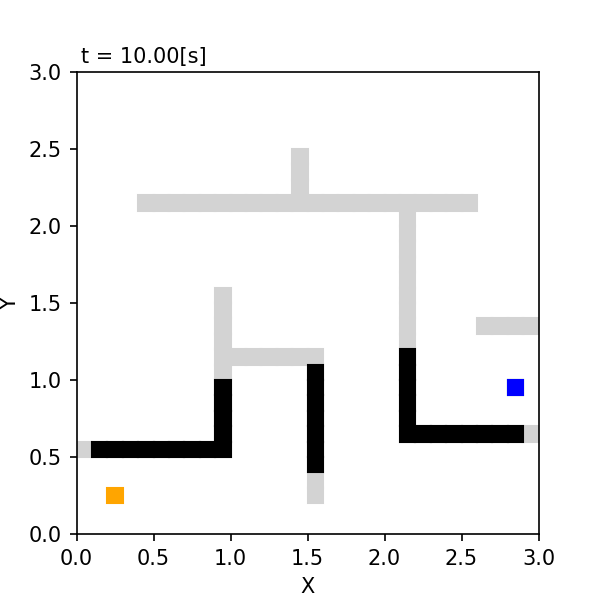

In [3]:
if __name__ == "__main__":
    time_span = 10
    time_interval = 0.1
    
    grid_step = np.array([0.1, 0.1])
    grid_num = np.array([30, 30])
    
    map_data = "csvmap/map2.csv"
    
    world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, debug=False, isDynamic=True)
    world.append(Dstar(world))
    
    world.draw()
    #world.ani.save('astar_map2.gif', writer='pillow', fps=100)    #アニメーション保存